# Atomic models for image simulation with ASE <a id='top'></a>

This notebook introduces the Atomic Simulation Environment ([ASE](https://wiki.fysik.dtu.dk/ase/)) for creating atomic models for image simulation.

ASE is a set of tools and Python modules for setting up, manipulating and visualizing atomic structures, which is used in conjunction with a large number of atomistic simulation codes, for example [GPAW](https://wiki.fysik.dtu.dk/gpaw/) for running DFT simulations. In this notebook, ASE is introduced in the context of running electron microscopy image simulations with [*ab*TEM](https://abtem.github.io/doc/intro.html). 

### Contents

1. <a href='#the_atoms_object'> The Atoms object
2. <a href='#importing_structures'> Importing structures from files
3. <a href='#visualization'> Visualization
4. <a href='#manipulating'> Manipulating atoms
5. <a href='#exporting_structures'> Exporting structures to files
6. <a href='#orthogonal'> Orthogonal and periodic supercells

In [1]:
%matplotlib inline

import abtem
import ase
import matplotlib.pyplot as plt
import numpy as np
from ase.visualize import view

##  The `Atoms` object <a id='the_atoms_object'></a>

The `Atoms` object defines a collection of atoms. To define `Atoms` from scratch, we need to specify at least three things:

* atomic positions,
* atomic numbers,
* a periodic cell.

Here, we create a basic model of the N<sub>2</sub> molecule.

In [2]:
atoms = ase.Atoms("N2", positions=[(0.0, 0.0, 0.0), (1.0, 0.0, 0.0)], cell=[3, 3, 3])

__Note__: *ab*TEM and ASE uses the same [unit conventions](https://wiki.fysik.dtu.dk/ase/ase/units.html), as defined in the `ase.units` module. Thus, electron volts (eV), Ångström (Å), and atomic mass units are defined as 1.0.

We can access the corresponding properties as attributes of the object we've defined.

In [3]:
atoms.positions

array([[0., 0., 0.],
       [1., 0., 0.]])

In [4]:
atoms.numbers

array([7, 7])

In [5]:
atoms.cell

Cell([3.0, 3.0, 3.0])

The `Atoms` can be modified by directly changing the underlying NumPy arrays. For instance, we can create NO by changing the atomic number of one of the N atoms.

In [6]:
atoms.numbers[0] = 8

We can further add an additional N atom to create nitrous oxide; convenient arithmetic operations work for the `Atoms` object.

In [7]:
atoms += ase.Atoms("N", positions=[(2.0, 0, 0)])

atoms

Atoms(symbols='ON2', pbc=False, cell=[3.0, 3.0, 3.0])

## Visualization <a id='visualization'></a>

We can visualize the atoms using the Matplotlib backend with *ab*TEM's `show_atoms` function, which shows a 2D projection of the structure perpendicular to a specified plane (by default $xy$, ie. perpendicular to the propagation direction).

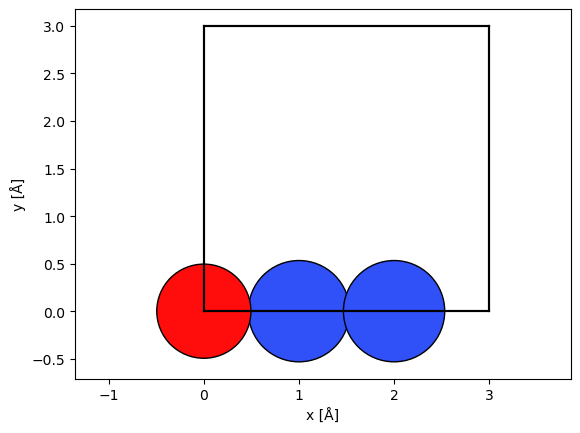

In [8]:
abtem.show_atoms(atoms);

The default ASE GUI, an interactive 3D viewer, may be started using the `view` function.

In [9]:
from ase.visualize import view

view(atoms);

## Importing structures from files <a id='importing_structures'></a>

ASE can import all common atomic-structure formats (full list [here](https://wiki.fysik.dtu.dk/ase/ase/io/io.html)). Below we import a `.cif`-file defining a unit cell of strontium titanate (SrTiO<sub>3</sub>) that we provided with this notebook.

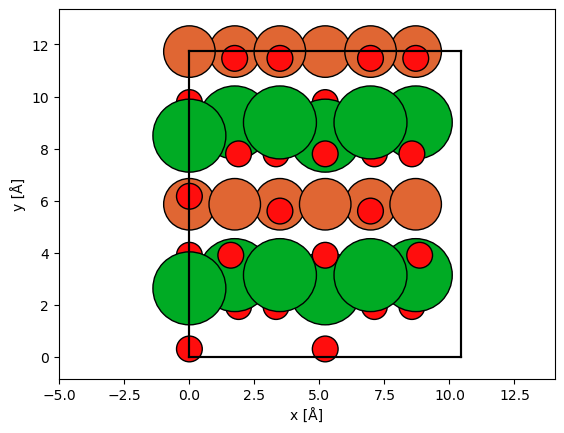

In [ ]:
# atoms = ase.io.read("sto_lto.cif")

import sys
sys.path.append('../..')
lufeo3 = ase.io.read("../../data/structures/LFO_LS.vasp")
atoms = abtem.orthogonalize_cell(lufeo3)
atoms.rotate(-120, v=[1, 1, 1], rotate_cell=True)  # one call, same result
# anything smaller in magnitude becomes exactly 0 or atoms will be lost at z = 0
tol = 1e-6 
atoms.positions[np.abs(atoms.positions) < tol] = 0.0
atoms.cell[np.abs(atoms.cell) < tol] = 0.0

abtem.show_atoms(atoms);

## Manipulating atoms <a id='manipulating'></a>
*ab*TEM always assumes that the imaging electrons propagate along the $z$-axis in the direction from _negative to positive_ coordinate values. Hence, to choose the zone axis, we need to manipulate the atoms so they are properly aligned.

ASE has so many tools for manipulating structures that we can't cover all of them here. As an example, we will look at the `surface` function, which can be used for creating a periodic surface (aligned with the $z$-axis) for a given set of Miller indices.

Below we orient the strontium titanate structure along the (110)-direction.

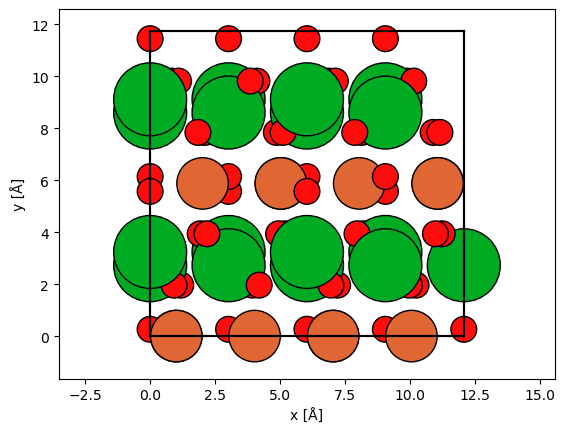

In [12]:
from ase.build import surface

srtio3_110 = surface(atoms, indices=(1, 1, 0), layers=2, periodic=True)

abtem.show_atoms(srtio3_110, plane="xy");

Simulations may require a larger crystal, to repeat the atoms by 2 in $x$, 4 in $y$ and 10 in the $z$-direction, we simply multiply the atoms.

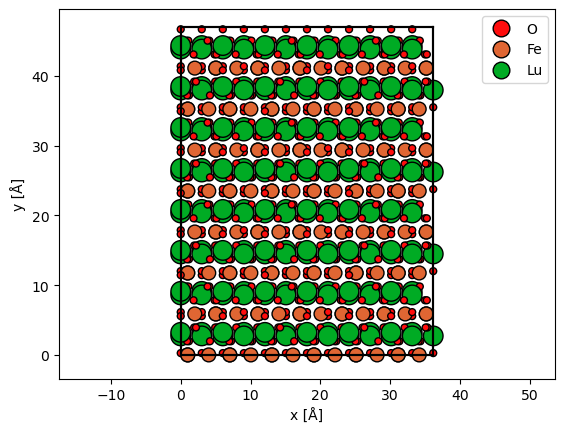

In [13]:
repeated_srtio3 = srtio3_110.copy()

repeated_srtio3 *= (3, 4, 10)

abtem.show_atoms(repeated_srtio3, legend=True);

To view the structure from the side, we can give a different `plane` keyword. We now see that that the model is slab a few nanometers in thickness.

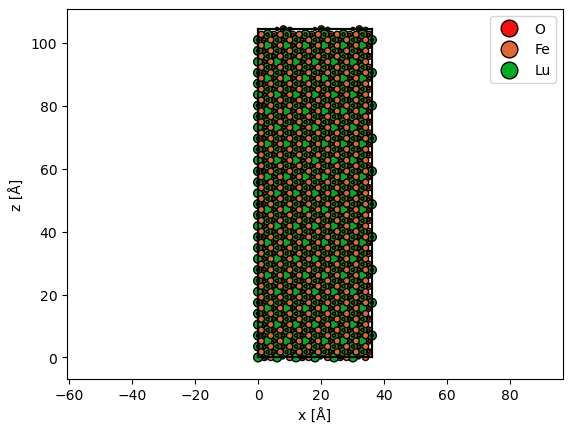

In [14]:
abtem.show_atoms(repeated_srtio3, legend=True, plane='xz');

The positions and atomic numbers are just `NumPy` arrays and hence can be modified in- place. Below, we create an SrTiO<sub>3</sub>/LaTiO<sub>3</sub> interface by changing the atomic numbers of the Sr atoms with a $y$-coordinate less than $7.5 \ \mathrm{Å}$.

Note that it is important to make a copy of the structure so that you avoid modifying the original object!

In [15]:
sto_lto = repeated_srtio3.copy()

mask = sto_lto.symbols == "Sr"

mask = mask * (sto_lto.positions[:, 1] < 7.5)

sto_lto.numbers[mask] = 57

Next, we center the atoms in the cell and add $5 \ \mathrm{Å}$ of vacuum at the entrance and exit surfaces along the $z$-axis.

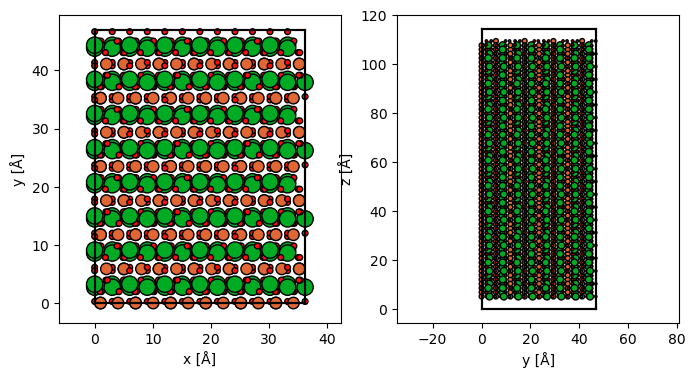

In [16]:
sto_lto.center(axis=2, vacuum=5)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
abtem.show_atoms(sto_lto, ax=ax1)
abtem.show_atoms(sto_lto, ax=ax2, plane="yz");

## Exporting structures to files <a id='exporting_structures'></a>

The structures can also be exported in all the common atomic structure formats. Here, we export the manipulated structure as `.cif`, so we can use it in the next tutorial. 

In [ ]:
from ase.io import write

# write("sto_lto.cif", sto_lto)

## Orthogonal and periodic supercells <a id='orthogonal'></a>

The multislice algorithm requires an orthogonal periodic atomic structure as its input. However, taking any arbitrary structure and making it periodic and orthogonal is often not trivial. *ab*TEM has a tool for solving this problem.

To demonstrate this, we create a graphene structure with the minimal hexagonal unit cell. 

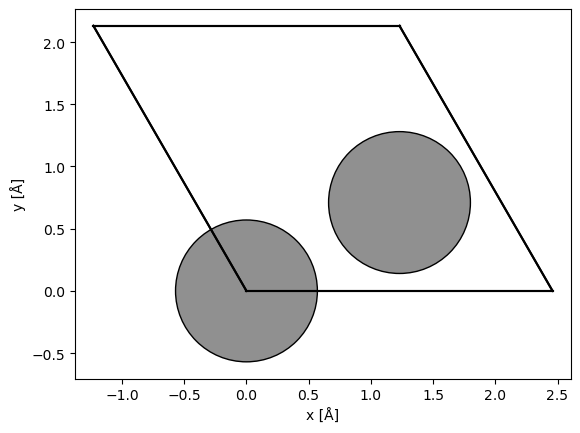

In [18]:
graphene = ase.build.graphene(vacuum=4)

abtem.show_atoms(graphene);

Applying `orthogonalize_cell`, we find the smallest orthogonal version of a cell. 

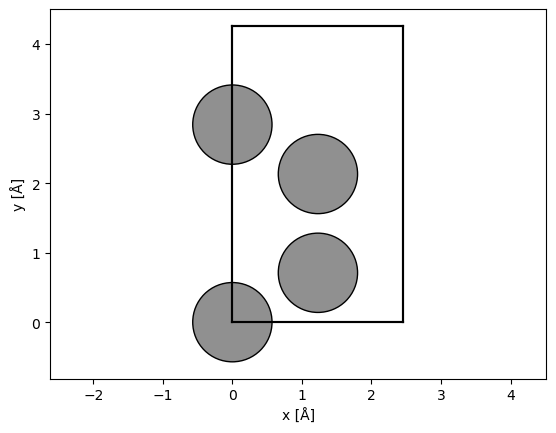

In [19]:
orthogonal_graphene = abtem.orthogonalize_cell(graphene)

abtem.show_atoms(orthogonal_graphene);

The problem of creating orthogonal cells is not always as trivial as for graphene. For those interested in more advanced uses of the `orthogonalize_cell` function, we have a [tutorial](https://abtem.github.io/doc/user_guide/tutorials/advanced_atomic_models.html) dedicated to the subject.